In [1]:
%matplotlib inline 
from mpl_toolkits.basemap import Basemap 
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset as NetCDFFile

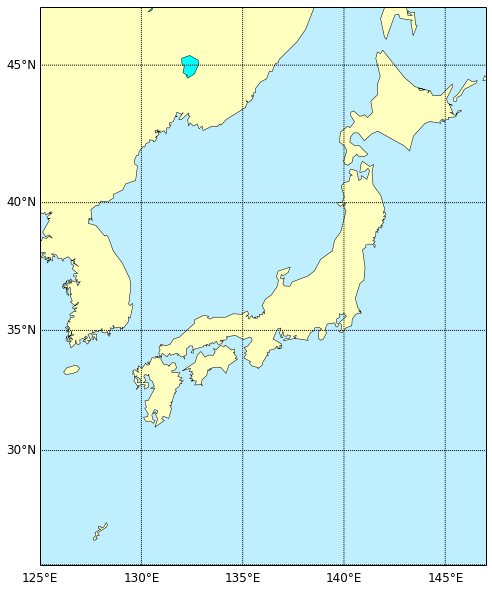

In [12]:
fig = plt.figure(figsize=(10,10))
m = Basemap(projection='merc',llcrnrlat=25.0,urcrnrlat=47.0,\
            llcrnrlon=125.0,urcrnrlon=147.0,resolution='l')
m.drawcoastlines(linewidth=0.5, color='#000000')
m.fillcontinents(color='#ffffbf',lake_color='#00ffff')
m.drawmapboundary(fill_color='#bfefff')

m.drawparallels(np.arange(25,50,5), labels = [1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(125,150,5), labels = [0,0,0,1], fontsize=12)
fnameF = "fig_japan.png"
plt.savefig(fnameF)
plt.show()

Basemap example from http://matplotlib.org/basemap/users/examples.html

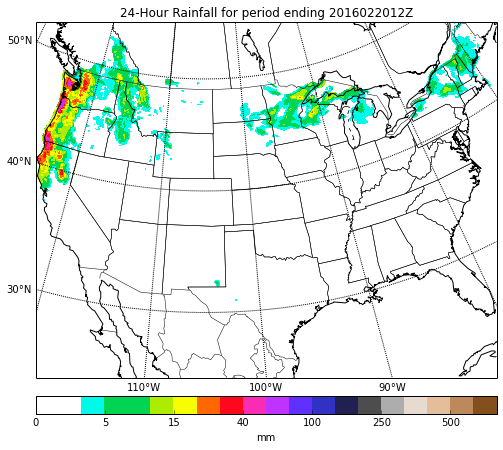

In [15]:
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt

nc = NetCDFFile('nws_precip_conus_20160220.nc')
# data from http://water.weather.gov/precip/
prcpvar = nc.variables['amountofprecip']
data = 0.01*prcpvar[:]
latcorners = nc.variables['lat'][:]
loncorners = -nc.variables['lon'][:]
lon_0 = -nc.variables['true_lon'].getValue()
lat_0 = nc.variables['true_lat'].getValue()
# create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,\
            llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],\
            rsphere=6371200.,resolution='l',area_thresh=10000)
# draw coastlines, state and country boundaries, edge of map.
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.
# draw filled contours.
clevs = [0,1,2.5,5,7.5,10,15,20,30,40,50,70,100,150,200,250,300,400,500,600,750]
cs = m.contourf(x,y,data,clevs,cmap=cm.s3pcpn)
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('mm')
# add title
plt.title(prcpvar.long_name+' for period ending '+prcpvar.dateofdata)
plt.show()

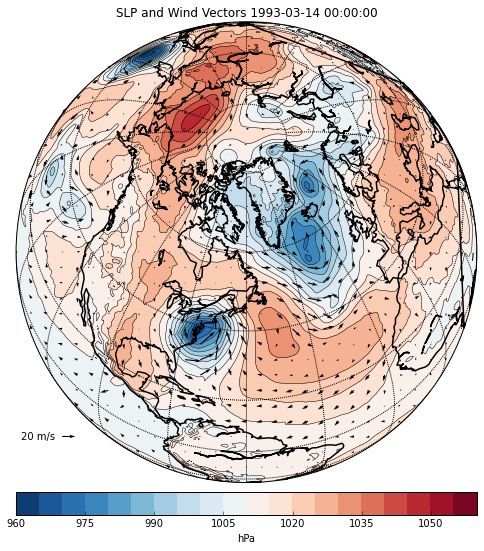

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
from netCDF4 import Dataset
# specify date to plot.
yyyy=1993; mm=03; dd=14; hh=00
date = datetime.datetime(yyyy,mm,dd,hh)
# set OpenDAP server URL.
URLbase="http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_pgbh/"
URL=URLbase+"%04i/%04i%02i/%04i%02i%02i/pgbh00.gdas.%04i%02i%02i%02i.grb2" %\
             (yyyy,yyyy,mm,yyyy,mm,dd,yyyy,mm,dd,hh)
data = Dataset(URL)
# read lats,lons
# reverse latitudes so they go from south to north.
latitudes = data.variables['lat'][::-1]
longitudes = data.variables['lon'][:].tolist()
# get sea level pressure and 10-m wind data.
# mult slp by 0.01 to put in units of hPa.
slpin = 0.01*data.variables['Pressure_msl'][:].squeeze()
uin = data.variables['U-component_of_wind_height_above_ground'][:].squeeze()
vin = data.variables['V-component_of_wind_height_above_ground'][:].squeeze()
# add cyclic points manually (could use addcyclic function)
slp = np.zeros((slpin.shape[0],slpin.shape[1]+1),np.float)
slp[:,0:-1] = slpin[::-1]; slp[:,-1] = slpin[::-1,0]
u = np.zeros((uin.shape[0],uin.shape[1]+1),np.float64)
u[:,0:-1] = uin[::-1]; u[:,-1] = uin[::-1,0]
v = np.zeros((vin.shape[0],vin.shape[1]+1),np.float64)
v[:,0:-1] = vin[::-1]; v[:,-1] = vin[::-1,0]
longitudes.append(360.); longitudes = np.array(longitudes)
# make 2-d grid of lons, lats
lons, lats = np.meshgrid(longitudes,latitudes)
# make orthographic basemap.
m = Basemap(resolution='c',projection='ortho',lat_0=60.,lon_0=-60.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])
# set desired contour levels.
clevs = np.arange(960,1061,5)
# compute native x,y coordinates of grid.
x, y = m(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
m.transform_vector(ugrid,vgrid,newlons,latitudes,31,31,returnxy=True,masked=True)
# now plot.
Q = m.quiver(xx,yy,uproj,vproj,scale=700)
# make quiver key.
qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')
# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)
# add colorbar
cb = m.colorbar(CS2,"bottom", size="5%", pad="2%")
cb.set_label('hPa')
# set plot title
ax.set_title('SLP and Wind Vectors '+str(date))
plt.show()

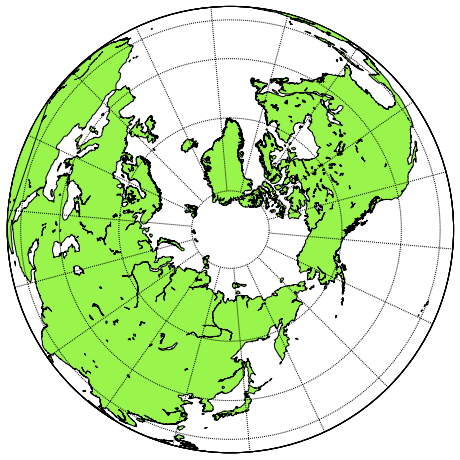

In [10]:
fig1 = plt.figure(figsize=(8,10))
m = Basemap(resolution='l',projection='ortho',lat_0=90.,lon_0=135.)
m.drawcoastlines(linewidth=1.)
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
m.drawparallels(parallels)
m.drawmeridians(meridians)
m.fillcontinents(color='#99f44c')
plt.show()

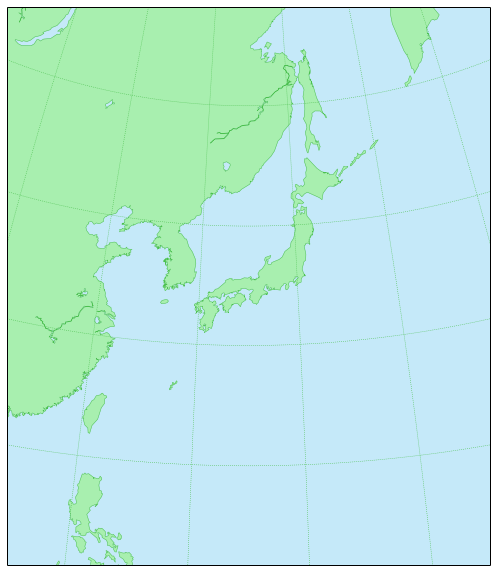

In [33]:
fig = plt.figure(figsize=(10,10))
m = Basemap(projection='stere',resolution='l', lon_0=135,lat_0=35,width=4500000,height=5200000)

m.drawcoastlines(linewidth=0.5, color='#4BC04E')
m.fillcontinents(color='#A8EFAF', lake_color='#C5E9F9')
m.drawmapboundary(fill_color='#C5E9F9')

m.drawparallels(np.arange(0,60,10), linewidth=0.5, color='#4BC04E')
m.drawmeridians(np.arange(100,170,10), linewidth=0.5, color='#4BC04E')
plt.show()